# TensorRT to speed up inference

*Prequisite : machine on GPU, 8GB ram and above? 

In this Notebook, we will have a simple tutorial of using TensorRT to speed up inference. We will be using a ResNet50 trained on ImageNet. 
Specifically, we will compare the performance multiple converted model graphs, starting from 
1. Our beloved Keras 
2. Tensorflow frozen graph
3. TensorRT converted inference graph. 

The notebook is compiled with environment running on python 3.6, tf-nightly-gpu 1.14, tensorrt 5.0.2.6 (tf-nightly does not work with newer versions) from a laptop with GTX 1060

![ResNet Residual](https://www.jeremyjordan.me/content/images/2018/04/Screen-Shot-2018-04-16-at-6.29.19-PM.png) 
Visualizing Resnet Residual Unit [link](https://www.jeremyjordan.me/convnet-architectures/)

In [1]:
# Import the libaries, we will start from Keras
import keras
from keras.applications.resnet50 import ResNet50
from keras import backend as K
import time
import numpy as np
import os
from trt_utils import FrozenGraph,TrtModel, TfModel, tf_to_trt_graph, write_graph_to_file

currdir = os.getcwd()

Using TensorFlow backend.
W0619 23:42:21.178220 140006771586816 deprecation_wrapper.py:118] From /home/cheeyau/anaconda3/envs/tensorrt/lib/python3.6/site-packages/tensorflow/__init__.py:95: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0619 23:42:21.179496 140006771586816 deprecation_wrapper.py:118] From /home/cheeyau/anaconda3/envs/tensorrt/lib/python3.6/site-packages/tensorflow/__init__.py:95: The name tf.AttrValue is deprecated. Please use tf.compat.v1.AttrValue instead.

W0619 23:42:21.180830 140006771586816 deprecation_wrapper.py:118] From /home/cheeyau/anaconda3/envs/tensorrt/lib/python3.6/site-packages/tensorflow/__init__.py:95: The name tf.COMPILER_VERSION is deprecated. Please use tf.version.COMPILER_VERSION instead.

W0619 23:42:21.182163 140006771586816 deprecation_wrapper.py:118] From /home/cheeyau/anaconda3/envs/tensorrt/lib/python3.6/site-packages/tensorflow/__init__.py:95: The name tf.CXX11_ABI_FLAG is deprecated. Please use tf.sysco

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Keras for inference

We start from a Keras ResNet pretrained model. In this notebook, we will randomly create images to test with each model. On an ideal scenario, each model should produce the same results

In [3]:
# Create Keras ResNet
model = ResNet50(weights='imagenet')
batch_size = 128 # this needs to be specified in TensorRT inference model

# Generate test samples 
img_shape = (224, 224, 3)
x_test = np.random.random_sample((batch_size,img_shape[0], img_shape[1], img_shape[2]))


W0619 23:42:29.640523 140006771586816 deprecation_wrapper.py:118] From /home/cheeyau/anaconda3/envs/tensorrt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0619 23:42:29.742252 140006771586816 deprecation_wrapper.py:118] From /home/cheeyau/anaconda3/envs/tensorrt/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Now we will run the examples through Keras and get the results and inference time.

In [4]:
y_keras = model.predict(x_test) # initialize the model first, don't take first predict into account
start = time.time()
y_keras = model.predict(x_test)
end = time.time()
Keras_time = end - start
print('Keras time : {0} s'.format(Keras_time) )

Keras time : 0.832683801651001 s


## Tensorflow for inference

Next we will convert the Keras model into a tensorflow frozen graph in the format of pb file. 
We will then use load this graph into tensorflow for inference.

In [5]:
frozen_graph = FrozenGraph(model, img_shape)

# Save the frozen file for reference
write_graph_to_file('resnet.pb',frozen_graph.frozen,currdir)

W0619 23:42:46.500216 140006771586816 deprecation.py:323] From /home/cheeyau/Git/Personal/TensorRT Next Extended/trt_utils.py:37: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0619 23:42:46.501111 140006771586816 deprecation.py:323] From /home/cheeyau/anaconda3/envs/tensorrt/lib/python3.6/site-packages/tensorflow_core/python/framework/graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
W0619 23:42:47.273081 140006771586816 deprecation.py:323] From /home/cheeyau/Git/Personal/TensorRT Next Extended/trt_utils.py:38: remove_training_nodes (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
In

In [6]:
print('number of nodes for tf model: {0}'.format(len(frozen_graph.frozen.node)))

number of nodes for tf model: 555


Now we will load the frozen file into a tensorflow engine and run the inference with the same samples

In [7]:
tf_model = TfModel(frozen_graph.frozen,frozen_graph.x_name,frozen_graph.y_name)

In [8]:
frozen_graph.x_name,frozen_graph.y_name

(['image_tensor_x'], ['resnet50/fc1000/Softmax'])

In [9]:
#tf_model = TfEngine(frozen_graph)
y_tf = tf_model.infer(x_test)
t0 = time.time() 
y_tf = tf_model.infer(x_test)
t1 = time.time()
tf_time = t1-t0

In [10]:
print('Tensorflow time : {0} s'.format(tf_time) )

Tensorflow time : 0.6611289978027344 s


## TensorRT for Inference

To perform infernce using TensorRT, first we need to optimize the tensorflow graph, this can be done using the tf_to_trt_graph function.

In [11]:
imagenet_classes = 1000
precision = "FP32"
x_name = ['image_tensor_x']
y_name =['resnet50/fc1000/Softmax']

In [13]:
tftrt_graph_fp32 = tf_to_trt_graph(frozen_graph.frozen, y_name, batch_size, precision)

In [14]:
write_graph_to_file('resnet_fp32.pb',tftrt_graph_fp32,currdir)

In [15]:
trt_model = TrtModel(tftrt_graph_fp32, batch_size,x_name,y_name, imagenet_classes)

In [16]:
y_tftrt = trt_model.infer(x_test)
t0 = time.time() 
y_tftrt = trt_model.infer(x_test)
t1 = time.time()
trt_time = t1-t0

In [17]:
print('TensorRT time : {0} s'.format(trt_time) )

TensorRT time : 0.43123412132263184 s


Above is a TensorRT optimization with precision FP32. This means only optimizing the tensor nodes and not precision. We can notice that using TensorRT we can improve the time by 25% of inference time. 

We will further explore optimizing with FP16, which lowers the precision by half.

In [12]:
imagenet_classes = 1000
precision = "FP16"
x_name = ['image_tensor_x']
y_name =['resnet50/fc1000/Softmax']
tftrt_graph_fp16 = tf_to_trt_graph(frozen_graph.frozen, y_name, batch_size, precision)
write_graph_to_file('resnet_fp16.pb',tftrt_graph_fp16,currdir)

In [13]:
trt_model = TrtModel(tftrt_graph_fp16, batch_size,x_name,y_name, imagenet_classes)

In [14]:
print('number of nodes for trt model: {0}'.format(len(tftrt_graph_fp16.node)))

number of nodes for trt model: 55


Notice how TensorRT convert the graph to 10 times lesser nodes! A question: does it means it is 10x faster? 

No, unfortunately it does not. TensorRT streamlines the process by converting multiple nodes into one, so the speed does not improve linearly, but it is definitely more efficient! Now let's look at the run time.

In [15]:
y_tftrt = trt_model.infer(x_test) # again we want to remove the time for the first try
t0 = time.time() 
y_tftrt = trt_model.infer(x_test)
t1 = time.time()
trt16_time = t1-t0

In [16]:
print('TensorRT time : {0} s'.format(trt16_time) )

TensorRT time : 0.4298059940338135 s


In [17]:
print('Keras time : {0} s'.format(Keras_time) )
print('Tensorflow time : {0} s'.format(tf_time) )
print('TensorRT time : {0} s'.format(trt16_time) )

Keras time : 0.832683801651001 s
Tensorflow time : 0.6611289978027344 s
TensorRT time : 0.4298059940338135 s


See how we observe a 60 % performance improvements with TensorRT. Now let's check the results. Ideally all models should give the same results. Here we provide a function to compare the error and return the error rate and show that there is no difference between the two models. 

In [18]:
def calculateErrorRate(result, ans):
    num_tests = ans.shape[0]
    error = 0
    for i in range(0, num_tests):
        a = np.argmax(ans[i])
        r = np.argmax(result[i])
        if (a != r) : error += 1
    
    error_rate = error/num_tests
    return error_rate

In [19]:
calculateErrorRate(y_tftrt,y_tf)

0.0

![Resnet Simplification](https://cdn-images-1.medium.com/max/880/0*EcYnWVTKabvE6mX5.)

This is the simplication of ResNet as published by Google and Nvidie [link](https://medium.com/tensorflow/speed-up-tensorflow-inference-on-gpus-with-tensorrt-13b49f3db3fa). Notice how the layers have been replaced with TensorRT specific operations. We do not generate and compare the graphs here due to some versions of tensorboard does not play well with this.

### Scaling up
We have seen how the model works with one batch of data. In real world, data comes in continuously and a model has to be able to cope with the prediction. We scale the the data to 15 batches, and see how the tensorrt model is able to perform up to 1.5x faster than tensorflow.

In [20]:
t0 = time.time() 
for i in range(15):
    x_test = np.random.random_sample((150,img_shape[0], img_shape[1], img_shape[2]))
    y_tf = tf_model.infer(x_test)
t1 = time.time()
print('Tensorflow time', t1 - t0)

Tensorflow time 17.601506233215332


In [21]:
t0 = time.time() 
for i in range(15):
    x_test = np.random.random_sample((150,img_shape[0], img_shape[1], img_shape[2]))
    y_tf = trt_model.infer(x_test)
t1 = time.time()
print('Tensorflow time', t1 - t0)

Tensorflow time 11.296567678451538


## Inference accuracy visualized

Now let's test our tensorflow and tensorRT model with a few images

In [22]:
from keras.applications.resnet50 import decode_predictions
import cv2
from matplotlib import pyplot as plt
from utils import printmd, load_img_array

In [23]:
img = cv2.imread('elephant.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

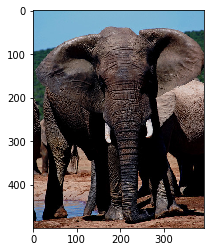

In [24]:
plt.imshow(img)

In [25]:

x = load_img_array('elephant.jpg')

In [26]:
tf_results = decode_predictions(tf_model.infer(x),top=3)[0]
trt_results = decode_predictions(trt_model.infer(x),top=3)[0]
printmd('**TF prediction:**' + str(tf_results))
printmd('**TRT FP 16 prediction:**' + str(trt_results))

**TF prediction:**[('n02504458', 'African_elephant', 0.46363816), ('n01871265', 'tusker', 0.45794216), ('n02504013', 'Indian_elephant', 0.0773115)]

**TRT FP 16 prediction:**[('n02504458', 'African_elephant', 0.46363863), ('n01871265', 'tusker', 0.45794174), ('n02504013', 'Indian_elephant', 0.077311434)]

The results are exactly the same ! This means we are achieving 40% improvement in speed with no loss in accuracy.

Let's test a few more

#### Lion

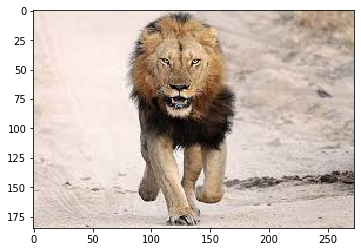

In [27]:
img = cv2.imread('lion.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [28]:
x = load_img_array('lion.jpg')
tf_results = decode_predictions(tf_model.infer(x),top=3)[0]
trt_results = decode_predictions(trt_model.infer(x),top=3)[0]
printmd('**TF prediction:**' + str(tf_results))
printmd('**TRT FP 16 prediction:**' + str(trt_results))

**TF prediction:**[('n02129165', 'lion', 0.9711367), ('n02108551', 'Tibetan_mastiff', 0.0070683304), ('n02403003', 'ox', 0.0035281891)]

**TRT FP 16 prediction:**[('n02129165', 'lion', 0.9711367), ('n02108551', 'Tibetan_mastiff', 0.0070683435), ('n02403003', 'ox', 0.0035281826)]

#### Human

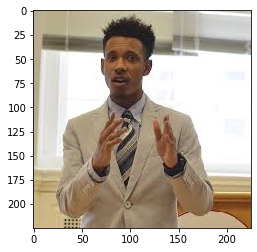

In [29]:
img = cv2.imread('human.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [30]:
x = load_img_array('human.jpg')
tf_results = decode_predictions(tf_model.infer(x),top=3)[0]
trt_results = decode_predictions(trt_model.infer(x),top=3)[0]
printmd('**TF prediction:**' + str(tf_results))
printmd('**TRT FP 16 prediction:**' + str(trt_results))

**TF prediction:**[('n04350905', 'suit', 0.54718727), ('n04591157', 'Windsor_tie', 0.442567), ('n02883205', 'bow_tie', 0.0048662224)]

**TRT FP 16 prediction:**[('n04350905', 'suit', 0.54718727), ('n04591157', 'Windsor_tie', 0.442567), ('n02883205', 'bow_tie', 0.004866204)]